In [1]:

from configs import imlenet_config
from models import imlenet
import tensorflow as tf
from data.datagen import DataGen
import pandas as pd


C:\Users\atila\anaconda3\envs\tfgpu_py3.10\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\atila\anaconda3\envs\tfgpu_py3.10\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file a

In [2]:
import main_preprocessing
data_split_result = main_preprocessing.run_preprocessing_steps()

{'seconds': 30, 'fs': 128, 'type_norm': 'standard', 'filters': ['lowpass', 'highpass', 'powerline']}


In [3]:
from preprocessing import preprocessing_chagas


In [4]:
import pickle

with open("data/data_219.pkl", 'rb') as fin:
    res = pickle.load(fin)

In [5]:
import numpy as np

all_data = res["data"].astype(np.float32)

<Axes: >

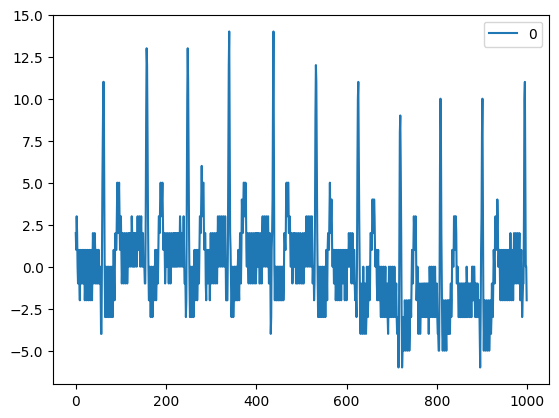

In [6]:
this_sample = all_data[10][:100000]

window_size = 5
ecg_median_filtered = preprocessing_chagas.median_filter(this_sample, fs=128)

pd.DataFrame(ecg_median_filtered.reshape(-1)[:1000]).plot()

<Axes: >

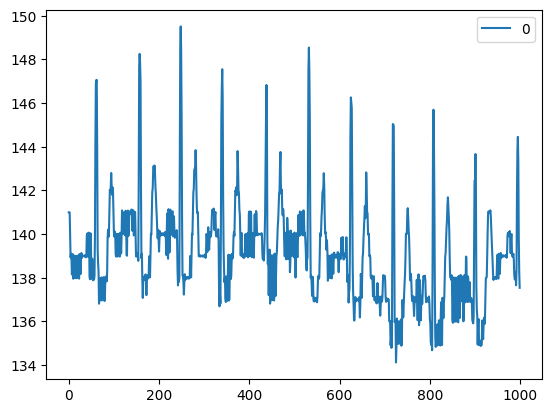

In [170]:
filtered_low_sample = preprocessing_chagas.low_pass_filter(ecg_median_filtered, cutoff_frequency=50, order=4)
pd.DataFrame(filtered_low_sample.reshape(-1)[:1000]).plot()

<Axes: >

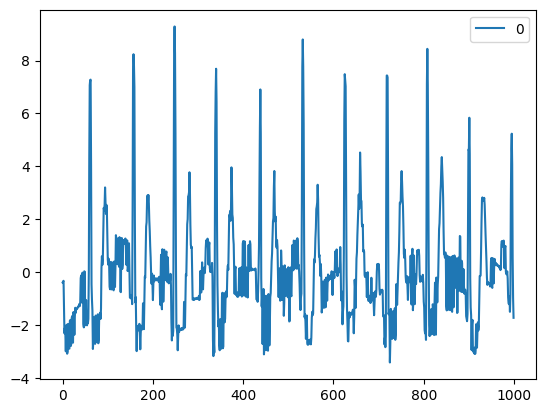

In [171]:
filtered_high_sample = preprocessing_chagas.high_pass_filter(filtered_low_sample, cutoff_frequency=0.5, order=4)
pd.DataFrame(filtered_high_sample.reshape(-1)[:1000]).plot()

<Axes: >

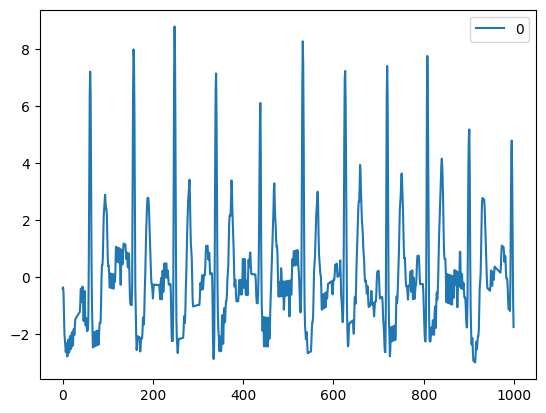

In [172]:
filtered_sample_powerline = preprocessing_chagas.powerline_filter(filtered_high_sample , fs=128, powerline=50)
pd.DataFrame(filtered_sample_powerline.reshape(-1)[:1000]).plot()

<Axes: >

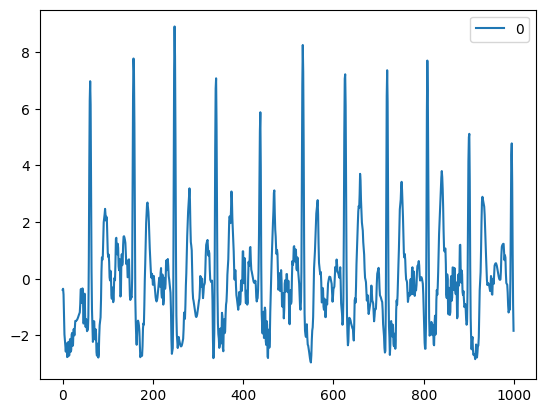

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, lfilter
from scipy.ndimage import median_filter

powerline_freq = 60
Q = 30.0  # Quality factor
f0 = powerline_freq  # Center frequency of the notch filter
b, a = iirnotch(f0, Q, fs)

# Apply the notch filter to the ECG signal
ecg_notch_filtered = lfilter(b, a, filtered_sample_powerline)
pd.DataFrame(ecg_notch_filtered.reshape(-1)[:1000]).plot()

In [155]:
filtered_sample_powerline.shape

(1, 100000)

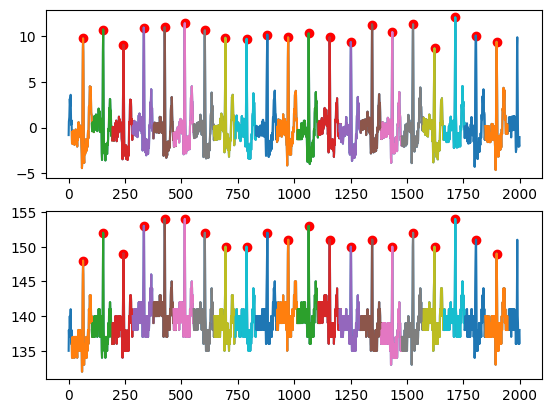

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from biosppy.signals import ecg

# Generate a sample ECG signal
np.random.seed(0)

start = 2000
end = 4000
ecg_signal = filtered_sample_powerline.ravel()[start:end].copy()

# Apply Pan-Tompkins QRS detection
out = ecg.ecg(signal=ecg_signal, sampling_rate=128, show=False, )

# Extract QRS complexes
qrs_indices = out['rpeaks']
qrs_complexes = [ecg_signal[i-50:i+50] for i in qrs_indices if i-50 >= 0 and i+50 < len(ecg_signal)]

# Plot original signal and QRS complexes

fig, (ax1, ax2) = plt.subplots(2, 1)

#ax1.figure(figsize=(6, 4))
ax1.plot(ecg_signal, label='Filtered ECG Signal')
for i, qrs in enumerate(qrs_complexes):
    ax1.plot(range(qrs_indices[i] - 50, qrs_indices[i] + 50), qrs, label=f'QRS Complex {i + 1}')
ax1.scatter(qrs_indices, ecg_signal[qrs_indices], color='red', label='Detected QRS Peaks')

ecg_signal_original = this_sample.ravel()[start:end].copy()
ax2.plot(ecg_signal_original, label='Original ECG Signal')
out = ecg.ecg(signal=ecg_signal_original, sampling_rate=128, show=False, )

qrs_indices = out['rpeaks']
qrs_complexes = [ecg_signal_original[i-50:i+50] for i in qrs_indices if i-50 >= 0 and i+50 < len(ecg_signal_original)]
for i, qrs in enumerate(qrs_complexes):
    ax2.plot(range(qrs_indices[i] - 50, qrs_indices[i] + 50), qrs, label=f'QRS Complex {i + 1}')
ax2.scatter(qrs_indices, ecg_signal_original[qrs_indices], color='red', label='Detected QRS Peaks')
